# Project 1: Sex Differences in brain organization

### Neuromaps decoding 

https://neuromaps.readthedocs.io 

## Load packages

In [1]:
# General
import os
import sys
import numpy as np
import pandas as pd
import csv
import math
from math import isnan
import statistics
import pingouin as pg
import pickle

# Computing / Analyses
import scipy.io  # loadmat
from scipy import stats
import sklearn 
from brainstat.stats.terms import FixedEffect
from brainstat.stats.SLM import SLM
from statsmodels.stats.multitest import fdrcorrection # does not yield exactly the same FDR correction as R but the same up to 14th decimal place so good enough
import statsmodels.regression.mixed_linear_model as sm

# Visualisation
import matplotlib.pyplot as plt 
import seaborn as sns
import vtk
from IPython.display import display
import matplotlib.collections as clt
import ptitprince as pt

# Neuroimaging
import nibabel
import nilearn
from brainstat.datasets import fetch_parcellation
from enigmatoolbox.permutation_testing import spin_test, shuf_test

# Gradients
import brainspace
from brainspace.datasets import load_parcellation, load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels

/data/u_serio_software/anaconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Define directories

In [2]:
codedir = os.path.abspath('')  # obtain current direction from which script is runnning

datadir = '/data/p_02667/sex_diff_gradients/data/'

resdir_hcp = '/data/p_02667/sex_diff_gradients/results/HCP/SA/'
resdir_fig = '/data/p_02667/sex_diff_gradients/results/figures/SA/'

## Import functions

In [79]:
%run p1_myfunctions.ipynb

# Data 

## Import the Yeo 7 network coding for the Schaefer 400 parcellation scheme 

(i.e., which network each parcel belongs to)

In [4]:
# labels: 1=visual, 2=sensory motor, 3=dorsal attention, 4=ventral attention, 5=limbic, 6=fronto parietal, 7= DMN

yeo7_networks_array = np.genfromtxt(datadir+'yeo_7.csv', delimiter=',', skip_header=0)

/data/u_serio_software/anaconda3/lib/python3.9/site-packages/brainspace/plotting/base.py:292: UserWarning: Support for interactive mode is only provided for a single renderer: 'nrow=1' and 'ncol=1'. Setting 'interactive=False'
  warnings.warn("Support for interactive mode is only provided for "


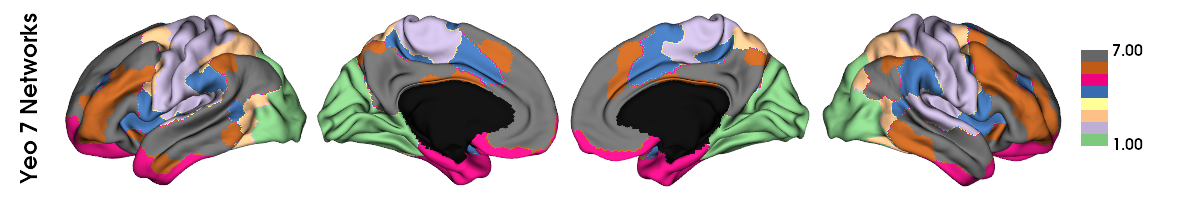

In [5]:
# defining labeling scheme and mask
labeling = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()

mask = labeling != 0

networks = map_to_labels(yeo7_networks_array, labeling, mask=mask, fill=np.nan)  # mean_grad contains 10 .gradients_ (1 gradient per column) - here I take all rows and individual select column based on gradient I want (first 3)

plot_hemispheres(surf_lh, surf_rh, array_name=networks, embed_nb = True, size=(1200, 200), cmap='Accent', color_bar=True, label_text=['Yeo 7 Networks'], zoom=1.55)


## Network labels ('Accent' cmap):
# 1 visual (green)
# 2 sensory motor (purple)
# 3 dorsal attention (beige)
# 4 ventral attention (blue)
# 5 limbic (fuchsia)
# 6 fronto parietal (brown)
# 7 DMN (grey)

This palette is to be used for every time that Yeo networks are displayed in color (except (a) for showing the networks plotted on the hemispheres - this dictionary doesn't work as cmap for plot_hemispheres; (b) the pie charts - dictionary format not recognized)

In [6]:
# original Yeo network colors
palette_labeled_networks = {'DMN': 'indianred',  
                            'dorsal attention' : 'forestgreen',  
                            'fronto parietal' : 'orange',  
                            'limbic' : 'lemonchiffon',  
                            'sensory motor' : 'steelblue',
                            'ventral attention' : 'orchid', 
                            'visual' : 'darkorchid'} 

This is not needed for the raincloud plot, just for the scatterplot G1 v G2 displaying networks

In [7]:
# making an array with yeo network labels (names instead of numbers)
yeo7_networks_array_labels = []

for i in yeo7_networks_array:
    if i == 1:
        yeo7_networks_array_labels.append('visual')
    elif i == 2:
        yeo7_networks_array_labels.append('sensory motor')
    elif i == 3:
        yeo7_networks_array_labels.append('dorsal attention')
    elif i == 4:
        yeo7_networks_array_labels.append('ventral attention')
    elif i == 5:
        yeo7_networks_array_labels.append('limbic')
    elif i == 6:
        yeo7_networks_array_labels.append('fronto parietal')
    elif i == 7:
        yeo7_networks_array_labels.append('DMN')

yeo7_networks_array_labels = np.asarray(yeo7_networks_array_labels)

In [8]:
network_names = ["visual", "sensory motor", "dorsal attention", "ventral attention", "limbic", "fronto parietal", "DMN"]

print("Number of parcels in each Yeo network:")
for i in range(len(network_names)):
    print(f"- {network_names[i]}: {yeo7_networks_array_labels.tolist().count(network_names[i])}")

Number of parcels in each Yeo network:
- visual: 61
- sensory motor: 77
- dorsal attention: 46
- ventral attention: 47
- limbic: 26
- fronto parietal: 53
- DMN: 90


## Fetch fsaverage parcellation (20484 vertices) coded for Schaefer 400 parcels - for Spin permutation tests

Spin permutation testing: https://enigma-toolbox.readthedocs.io/en/latest/pages/08.spintest/index.html -> requires data to be in fsaverage surface (not feasible with Schaefer parcellation)

**NOTE: schaefer_400_fs5 == 0 corresponds to midline (labels go from 0-400) -> disregard 0 in calculations and plotting**

In [9]:
# fetch the fsaverage parcellation labeling each of fsaverage5's 20484 vertices with its corresponding Schaefer parcel
schaefer_400_fs5 = fetch_parcellation("fsaverage5", "schaefer", 400)

## Descriptive HCP

In [10]:
HCP_demographics_cleaned_final = pd.read_csv(resdir_hcp+'demographics_cleaned_final.csv') 

## FC G1 sex contrast t-values

In [11]:
# loading R results

# HCP model: linear mixed effects model = Gradient_loadings ~ Sex + Age + tot_SA + random nested effect (family relatedness/twin status) 
R_lmer_hemi_fc_G1_sex_contrast_res = pd.read_csv(resdir_hcp+'R_lmer_hemi_fc_G1_sex_contrast_res.csv')  

In [12]:
R_lmer_hemi_fc_G1_sex_contrast_res.t_val

0     -0.719723
1     -4.147849
2      0.329707
3      0.116151
4      0.758524
         ...   
395   -5.146640
396   -0.811704
397   -0.508172
398   -2.551580
399   -3.859678
Name: t_val, Length: 400, dtype: float64

### Project to fsaverage space for neuromaps analysis

Project unimodal-heteromodal gradient eigenvalues (from Schaefer 400 parcellation) to fsaverage5's 20484 vertices

In [14]:
R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5 = []

# iterate over the 20484 vertices in fsaverage5
for i in range(len(schaefer_400_fs5)):
    
    if schaefer_400_fs5[i] == 0:  # corresponds to the midline
        # append to the lists of fs5_tvals: 0
        R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5.append(0)
        
    else:
        # append to the lists of fs5_tvals: the value of array being converted of the corresponding Schaefer parcel (here parcel value [i] - 1 because parcel numbers go from 1-400 instead of 0-399 as required for indexing)
        R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5.append(R_lmer_hemi_fc_G1_sex_contrast_res.t_val[schaefer_400_fs5[i]-1])

# change the zeros into nan (couldn't nan directly because then it made the array content strings
R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5[R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5 == 0] = np.nan

# transform list into array
R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5 = np.asarray(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5)


print(f"Length of fsaverage5 data: {len(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5)}")

Length of fsaverage5 data: 20484


# Neuromaps decoding

## Load neuromaps datasets

In [15]:
import neuromaps
from neuromaps.datasets import available_annotations
from neuromaps.datasets import available_tags
from neuromaps.datasets import fetch_annotation
from neuromaps import transforms
from neuromaps.resampling import resample_images

## Load neuromaps datasets

### Browse available maps

In [16]:
for annotation in available_annotations():
    print(annotation)

('abagen', 'genepc1', 'fsaverage', '10k')
('aghourian2017', 'feobv', 'MNI152', '1mm')
('alarkurtti2015', 'raclopride', 'MNI152', '3mm')
('bedard2019', 'feobv', 'MNI152', '1mm')
('beliveau2017', 'az10419369', 'MNI152', '1mm')
('beliveau2017', 'az10419369', 'fsaverage', '164k')
('beliveau2017', 'cimbi36', 'MNI152', '1mm')
('beliveau2017', 'cimbi36', 'fsaverage', '164k')
('beliveau2017', 'cumi101', 'MNI152', '1mm')
('beliveau2017', 'cumi101', 'fsaverage', '164k')
('beliveau2017', 'dasb', 'MNI152', '1mm')
('beliveau2017', 'dasb', 'fsaverage', '164k')
('beliveau2017', 'sb207145', 'MNI152', '1mm')
('beliveau2017', 'sb207145', 'fsaverage', '164k')
('ding2010', 'mrb', 'MNI152', '1mm')
('dubois2015', 'abp688', 'MNI152', '1mm')
('dukart2018', 'flumazenil', 'MNI152', '3mm')
('dukart2018', 'fpcit', 'MNI152', '3mm')
('fazio2016', 'madam', 'MNI152', '3mm')
('finnema2016', 'ucbj', 'MNI152', '1mm')
('gallezot2010', 'p943', 'MNI152', '1mm')
('gallezot2017', 'gsk189254', 'MNI152', '1mm')
('hcps1200', 'm

In [17]:
print(available_tags())

['ASL', 'MEG', 'MRI', 'PET', 'fMRI', 'functional', 'genetics', 'meta-analysis', 'receptors', 'structural']


In [18]:
for annotation in available_annotations(tags=['meta-analysis']):
    print(annotation)

('neurosynth', 'cogpc1', 'MNI152', '2mm')


In [19]:
for annotation in available_annotations(tags=['genetics']):
    print(annotation)

('abagen', 'genepc1', 'fsaverage', '10k')


In [20]:
for annotation in available_annotations(tags=['ASL']):
    print(annotation)

('satterthwaite2014', 'meancbf', 'MNI152', '1mm')


In [21]:
for annotation in available_annotations(tags=['PET']):
    print(annotation)

('aghourian2017', 'feobv', 'MNI152', '1mm')
('alarkurtti2015', 'raclopride', 'MNI152', '3mm')
('bedard2019', 'feobv', 'MNI152', '1mm')
('beliveau2017', 'az10419369', 'MNI152', '1mm')
('beliveau2017', 'az10419369', 'fsaverage', '164k')
('beliveau2017', 'cimbi36', 'MNI152', '1mm')
('beliveau2017', 'cimbi36', 'fsaverage', '164k')
('beliveau2017', 'cumi101', 'MNI152', '1mm')
('beliveau2017', 'cumi101', 'fsaverage', '164k')
('beliveau2017', 'dasb', 'MNI152', '1mm')
('beliveau2017', 'dasb', 'fsaverage', '164k')
('beliveau2017', 'sb207145', 'MNI152', '1mm')
('beliveau2017', 'sb207145', 'fsaverage', '164k')
('ding2010', 'mrb', 'MNI152', '1mm')
('dubois2015', 'abp688', 'MNI152', '1mm')
('dukart2018', 'flumazenil', 'MNI152', '3mm')
('dukart2018', 'fpcit', 'MNI152', '3mm')
('fazio2016', 'madam', 'MNI152', '3mm')
('finnema2016', 'ucbj', 'MNI152', '1mm')
('gallezot2010', 'p943', 'MNI152', '1mm')
('gallezot2017', 'gsk189254', 'MNI152', '1mm')
('hesse2017', 'methylreboxetine', 'MNI152', '3mm')
('hill

In [22]:
for annotation in available_annotations(tags=['receptors']):
    print(annotation)

('aghourian2017', 'feobv', 'MNI152', '1mm')
('alarkurtti2015', 'raclopride', 'MNI152', '3mm')
('bedard2019', 'feobv', 'MNI152', '1mm')
('beliveau2017', 'az10419369', 'MNI152', '1mm')
('beliveau2017', 'az10419369', 'fsaverage', '164k')
('beliveau2017', 'cimbi36', 'MNI152', '1mm')
('beliveau2017', 'cimbi36', 'fsaverage', '164k')
('beliveau2017', 'cumi101', 'MNI152', '1mm')
('beliveau2017', 'cumi101', 'fsaverage', '164k')
('beliveau2017', 'dasb', 'MNI152', '1mm')
('beliveau2017', 'dasb', 'fsaverage', '164k')
('beliveau2017', 'sb207145', 'MNI152', '1mm')
('beliveau2017', 'sb207145', 'fsaverage', '164k')
('ding2010', 'mrb', 'MNI152', '1mm')
('dubois2015', 'abp688', 'MNI152', '1mm')
('dukart2018', 'flumazenil', 'MNI152', '3mm')
('dukart2018', 'fpcit', 'MNI152', '3mm')
('fazio2016', 'madam', 'MNI152', '3mm')
('gallezot2010', 'p943', 'MNI152', '1mm')
('gallezot2017', 'gsk189254', 'MNI152', '1mm')
('hesse2017', 'methylreboxetine', 'MNI152', '3mm')
('hillmer2016', 'flubatine', 'MNI152', '1mm')
(

In [23]:
for annotation in available_annotations(tags=['structural']):
    print(annotation)

('hcps1200', 'myelinmap', 'fsLR', '32k')
('hcps1200', 'thickness', 'fsLR', '32k')
('hill2010', 'devexp', 'fsLR', '164k')
('hill2010', 'evoexp', 'fsLR', '164k')
('neurosynth', 'cogpc1', 'MNI152', '2mm')
('reardon2018', 'scalinghcp', 'civet', '41k')
('reardon2018', 'scalingnih', 'civet', '41k')
('reardon2018', 'scalingpnc', 'civet', '41k')
('xu2020', 'evoexp', 'fsLR', '32k')


### Selecting maps of interest

In [24]:
# when there are multiple maps under the same source, fetch annotation loads all in 1 dictionary so need to index the one I want

neurosynth = fetch_annotation(source='neurosynth')
abagen = fetch_annotation(source='abagen')
cbf = fetch_annotation(source='satterthwaite2014')  
dopa = fetch_annotation(source='alarkurtti2015')
acetylcholine = fetch_annotation(source='bedard2019')
sert = fetch_annotation(source='beliveau2017')[('beliveau2017', 'dasb', 'fsaverage', '164k')]
norepinephrin = fetch_annotation(source='ding2010')
glucose = fetch_annotation(source='dubois2015')

devexp = fetch_annotation(source='hill2010')[('hill2010', 'devexp', 'fsLR', '164k')]  # note that map only has data for right hemisphere
evoexp = fetch_annotation(source='hill2010')[('hill2010', 'evoexp', 'fsLR',  '164k')]  # note that map only has data for right hemisphere

/data/u_serio_software/anaconda3/lib/python3.9/site-packages/neuromaps/datasets/annotations.py:238: UserWarning: Data from beliveau2017 and norgaard2021 is best used in the provided fsaverage space (e.g. source='beliveau2017', space='fsaverage', den='164k'). MNI152 maps should only be used for subcortical data.
  warnings.warn('Data from beliveau2017 and norgaard2021 is best used in'


### Transforming maps to fsaverage space

#### One at the time

#### Resample to common space (2 at the same time)

In [87]:
neurosynth_fsaverage, abagen_fsaverage = resample_images(src=neurosynth, trg=abagen,
                                    src_space='MNI152', trg_space='fsaverage',
                                    method='linear', resampling='transform_to_alt',
                                    alt_spec=('fsaverage', '10k'))  # specifies the target coordinate system and density

In [88]:
cbf_fsaverage, dopa_fsaverage = resample_images(src=cbf, trg=dopa,
                                    src_space='MNI152', trg_space='MNI152',
                                    method='linear', resampling='transform_to_alt',
                                    alt_spec=('fsaverage', '10k'))  # specifies the target coordinate system and density

In [89]:
acetylcholine_fsaverage, sert_fsaverage = resample_images(src=acetylcholine, trg=sert,
                                    src_space='MNI152', trg_space='fsaverage',
                                    method='linear', resampling='transform_to_alt',
                                    alt_spec=('fsaverage', '10k'))  # specifies the target coordinate system and density

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-07-11 14:36:36,411 - nibabel.global - INFO - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [90]:
norepinephrin_fsaverage, glucose_fsaverage = resample_images(src=norepinephrin, trg=glucose,
                                    src_space='MNI152', trg_space='MNI152',
                                    method='linear', resampling='transform_to_alt',
                                    alt_spec=('fsaverage', '10k'))  # specifies the target coordinate system and density

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-07-11 14:36:41,618 - nibabel.global - INFO - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [91]:
devexp_fsaverage_rh, evoexp_fsaverage_rh = resample_images(src=devexp, trg=evoexp,
                                    src_space='fsLR', trg_space='fsLR',
                                    method='linear', resampling='transform_to_alt',
                                    hemi='R',
                                    alt_spec=('fsaverage', '10k'))  # specifies the target coordinate system and density

#### Reshape the maps into useable format

In [92]:
# get the data loaded on left and right hemispheres (GIFTY images)
neurosynth_fsaverage_lh, neurosynth_fsaverage_rh = neurosynth_fsaverage
abagen_fsaverage_lh, abagen_fsaverage_rh = abagen_fsaverage
cbf_fsaverage_lh, cbf_fsaverage_rh = cbf_fsaverage
dopa_fsaverage_lh, dopa_fsaverage_rh = dopa_fsaverage
acetylcholine_fsaverage_lh, acetylcholine_fsaverage_rh = acetylcholine_fsaverage
sert_fsaverage_lh, sert_fsaverage_rh = sert_fsaverage
norepinephrin_fsaverage_lh, norepinephrin_fsaverage_rh = norepinephrin_fsaverage
glucose_fsaverage_lh, glucose_fsaverage_rh = glucose_fsaverage

# concatenate left and right hemispheres (using agg_data() to obtain data values from GIFTY images in numpy array)
neurosynth_fsaverage_wb = np.concatenate((neurosynth_fsaverage_lh.agg_data(), neurosynth_fsaverage_rh.agg_data()))
abagen_fsaverage_wb = np.concatenate((abagen_fsaverage_lh.agg_data(), abagen_fsaverage_rh.agg_data()))
cbf_fsaverage_wb = np.concatenate((cbf_fsaverage_lh.agg_data(), cbf_fsaverage_rh.agg_data()))
dopa_fsaverage_wb = np.concatenate((dopa_fsaverage_lh.agg_data(), dopa_fsaverage_rh.agg_data()))
acetylcholine_fsaverage_wb = np.concatenate((acetylcholine_fsaverage_lh.agg_data(), acetylcholine_fsaverage_rh.agg_data()))
sert_fsaverage_wb = np.concatenate((sert_fsaverage_lh.agg_data(), sert_fsaverage_rh.agg_data()))
norepinephrin_fsaverage_wb = np.concatenate((norepinephrin_fsaverage_lh.agg_data(), norepinephrin_fsaverage_rh.agg_data()))
glucose_fsaverage_wb = np.concatenate((glucose_fsaverage_lh.agg_data(), glucose_fsaverage_rh.agg_data()))


# only right hemispheres - still need to get the data values from GIFTY images (but no concatenation of hemispheres)
devexp_fsaverage_rh = devexp_fsaverage_rh[0].agg_data()
evoexp_fsaverage_rh = evoexp_fsaverage_rh[0].agg_data()


### make ordered lists (for later table and plotting) 

# names of neuromaps
neuromap_names = ['neurosynth',
                  'abagen',
                  'cbf',
                  'dopamine',
                  'acetylcholine',
                  'serotonin',
                  'norepinephrin',
                  'glucose',
                  'developmental expansion',
                  'evolutionary expansion']


# neuromaps (data)
neuromaps = [neurosynth_fsaverage_wb, 
             abagen_fsaverage_wb, 
             cbf_fsaverage_wb, 
             dopa_fsaverage_wb, 
             acetylcholine_fsaverage_wb, 
             sert_fsaverage_wb, 
             norepinephrin_fsaverage_wb, 
             glucose_fsaverage_wb, 
             devexp_fsaverage_rh, 
             evoexp_fsaverage_rh]

## Analyses: associations of t-values sex contrast FC G1 with neuromaps

In [75]:
# not using this anymore (too stringent) -> using FDR correction instead

print(f"Bonferroni corection threshold: {0.05/10}")

Bonferroni corection threshold: 0.005


### Compute correlations between t-map sex contrast FC G1 and each neuromap

------------ neurosynth ------------

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Spin permutation test p-value: 0.046


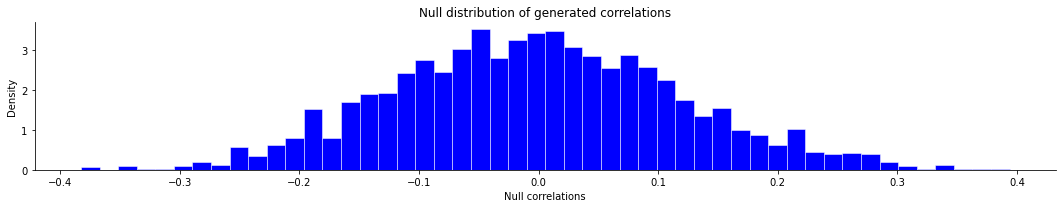

------------ abagen ------------

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Spin permutation test p-value: 0.0325


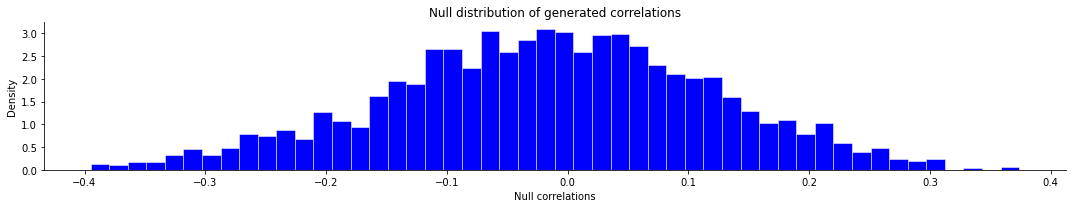

------------ cbf ------------

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Spin permutation test p-value: 0.0115


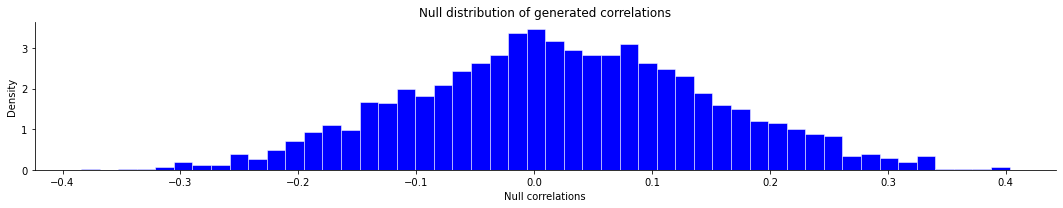

------------ dopamine ------------

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Spin permutation test p-value: 0.4645


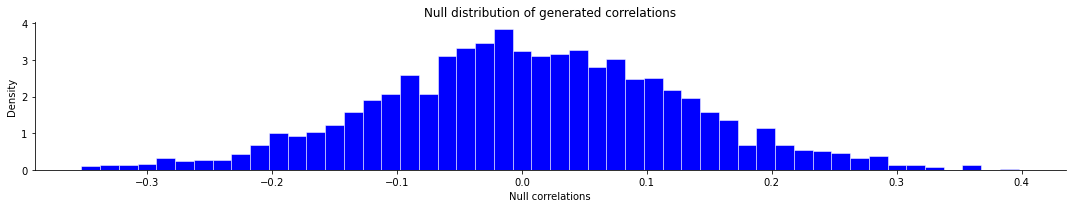

------------ acetylcholine ------------

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Spin permutation test p-value: 0.16849999999999998


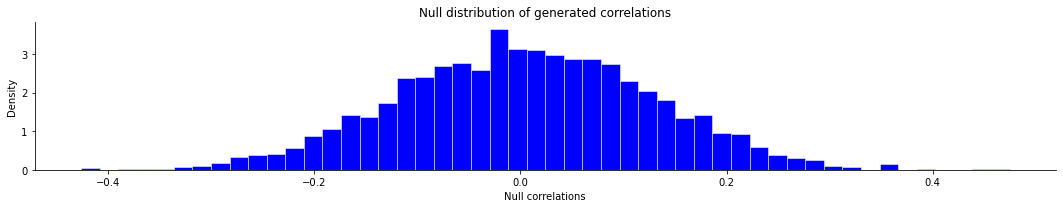

------------ serotonin ------------

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Spin permutation test p-value: 0.2425


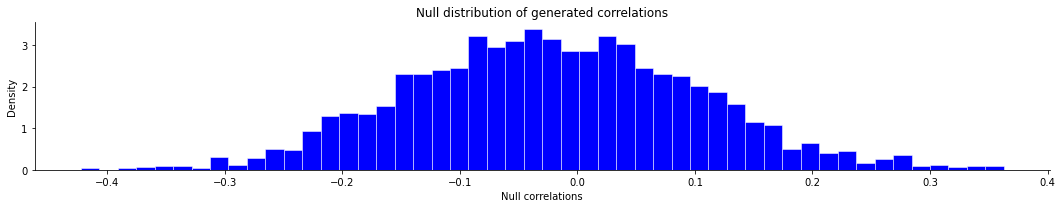

------------ norepinephrin ------------

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Spin permutation test p-value: 0.152


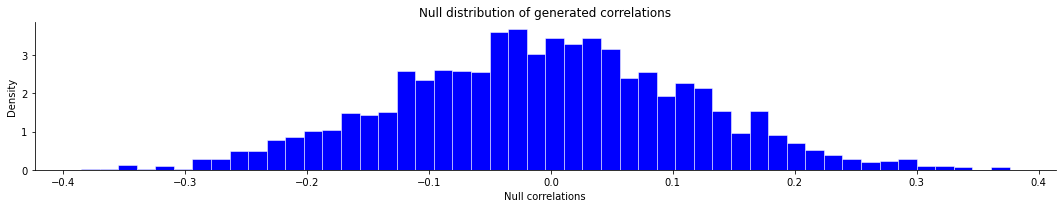

------------ glucose ------------

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Spin permutation test p-value: 0.0375


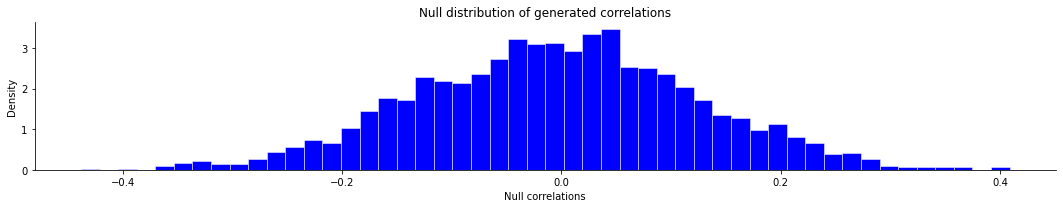

------------ developmental expansion ------------

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Spin permutation test p-value: 0.446


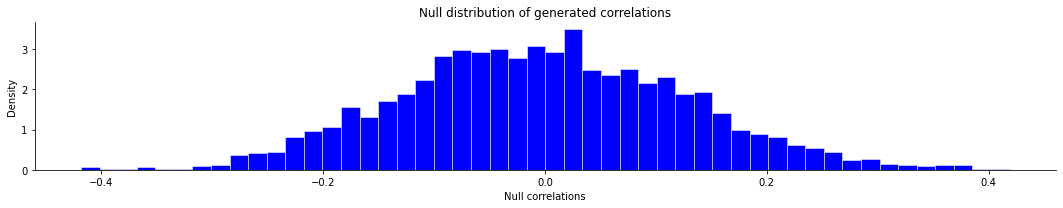

------------ evolutionary expansion ------------

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Spin permutation test p-value: 0.020999999999999998


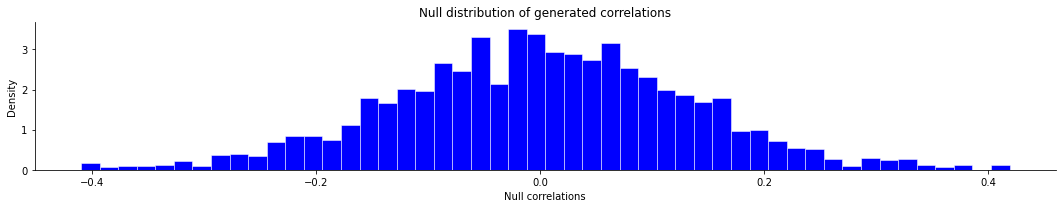

In [129]:
r_vals = []
p_vals = []
spin_p_vals = []
null_distr_rvals = []


for i in range(len(neuromap_names)):
    
    print(f"------------ {neuromap_names[i]} ------------\n")
    
    # whole brain
    if len(neuromaps[i]) == 20484:
    
        # r value
        r_vals.append(stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, neuromaps[i], nan_policy='omit')[0])

        # uncorrected p value
        p_vals.append(stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, neuromaps[i], nan_policy='omit')[1])

        # spin permutation test (spin p value, null distribution of r values)
        spin_test = SpinPermutationTest_Schaefer400(x = R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, y = neuromaps[i], correlation_type = 'spearman')
        
    
    # only one hemisphere -> I hard code it knowing that it's the right hemisphere
    elif len(neuromaps[i]) == 10242:
    
        # r value
        r_vals.append(stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5[10242:], neuromaps[i], nan_policy='omit')[0])

        # uncorrected p value
        p_vals.append(stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5[10242:], neuromaps[i], nan_policy='omit')[1])

        # spin permutation test (spin p value, null distribution of r values)
        spin_test = SpinPermutationTest_Schaefer400(x = R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5[10242:], y = neuromaps[i], correlation_type = 'spearman')
    
    
    
    spin_p_vals.append(spin_test['spin_test_p'])
    null_distr_rvals.append(spin_test['spin_test_d'])
    

# make a dictionary to store in dataframe
neuromaps_res = {'neuromap_names': neuromap_names, 
                 'spearman (r)': r_vals,
                 'uncorrected p': p_vals,
                 'spin p': spin_p_vals,
                 'spin q': fdrcorrection(pvals = spin_p_vals, alpha=0.05)[1],
                 'significance (FDR-corrected)': fdrcorrection(pvals = spin_p_vals, alpha=0.05)[0]}

neuromaps_res = pd.DataFrame(neuromaps_res)

### Results summary with FDR correction

# !!! RESULTS ARE NO LONGER SINGIFICANT AFTER FDR CORRECTION.... what to do? - old results below

In [130]:
neuromaps_res

,neuromap_names,spearman (r),uncorrected p,spin p,spin q,significance (FDR-corrected)
0,neurosynth,0.023635,7.172609e-04,0.0460,0.092000,False
1,abagen,-0.126626,1.001778e-66,0.0325,0.092000,False
2,cbf,0.352219,0.000000e+00,0.0115,0.092000,False
3,dopamine,0.127404,7.210485e-75,0.4645,0.464500,False
4,acetylcholine,0.122679,1.632810e-69,0.1685,0.240714,False
5,serotonin,0.031909,4.932516e-06,0.2425,0.303125,False
6,norepinephrin,0.026291,1.677728e-04,0.1520,0.240714,False
7,glucose,0.214754,2.650163e-212,0.0375,0.092000,False
8,developmental expansion,0.018856,5.665675e-02,0.4460,0.464500,False
9,evolutionary expansion,0.251187,8.265922e-147,0.0210,0.092000,False


#### Export results dataframe to csv

### Plot null r distributions

# NOTE that the function outputs 2x number of rotations https://enigma-toolbox.readthedocs.io/en/latest/pages/13.01.apireference/generated/enigmatoolbox.permutation_testing.spin_test.html#enigmatoolbox.permutation_testing.spin_test -> weird - Meike says matlab function automatically averages them (and that they correspond to spinning one map first, then the other) - I was thinking I should take one of the two halves and keeping that? since I want null distribution to be same length as the number of rotations

[Text(0, 0, 'neurosynth'),
 Text(1, 0, 'abagen'),
 Text(2, 0, 'cbf'),
 Text(3, 0, 'dopamine'),
 Text(4, 0, 'acetylcholine'),
 Text(5, 0, 'serotonin'),
 Text(6, 0, 'norepinephrin'),
 Text(7, 0, 'glucose'),
 Text(8, 0, 'developmental expansion'),
 Text(9, 0, 'evolutionary expansion')]

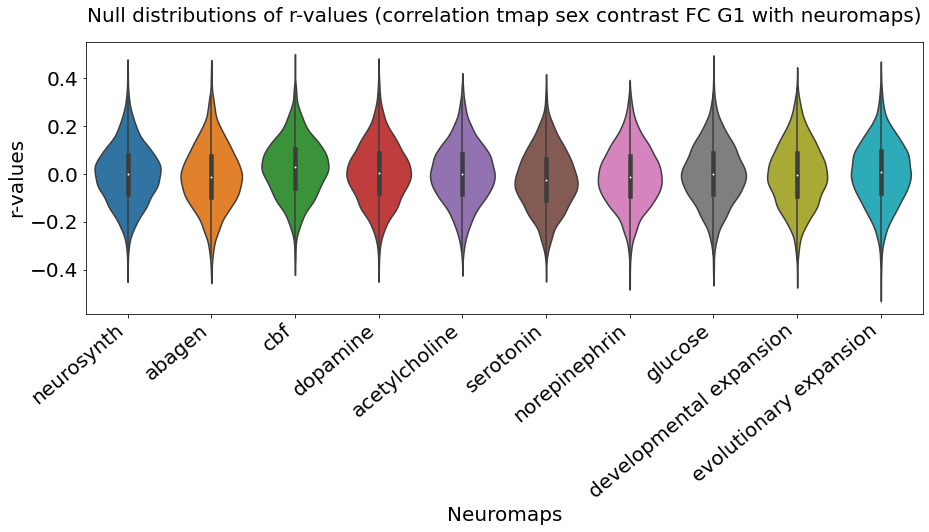

In [128]:
### Violin plot of t-values (null distributions) by neuromap - in order to show where the empirical t-value is located

df_null_distr_neuromaps = pd.DataFrame(np.array(null_distr_rvals).T, columns = neuromap_names)


df_null_distr_neuromaps_long = pd.melt(df_null_distr_neuromaps,
                                       value_vars = df_null_distr_neuromaps.columns.tolist(),
                                       var_name = 'neuromap', value_name='r_vals', ignore_index=False)





fig, ax = plt.subplots(figsize=(15, 5))


sns.violinplot(data = df_null_distr_neuromaps_long,
                    x="neuromap",
                    y="r_vals",
                    #hue="",
                    #palette = palette_labeled_networks,
                    split = False)

ax.axes.set_title("Null distributions of r-values (correlation tmap sex contrast FC G1 with neuromaps)", y=1.05, fontsize=20)
ax.set_xlabel("Neuromaps",fontsize=20)
ax.set_ylabel("r-values",fontsize=20)
ax.tick_params(labelsize=20)
#ax.set_xticklabels('', rotation=40, ha="right") 
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")  # to show tick labels

#plt.show()

# save figure in directory 
#plt.savefig(resdir_fig+'HCP_violin_neuromaps_null_distr_rvals.png', dpi=300, bbox_inches="tight")  # bbox_inches is so that the figure doesn't get cut off when saving

#
#
# old version (one by one) that yielded the few significant results

### Neurosynth

In [54]:
neuromap.append('neurosynth')
r_vals.append(stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, neurosynth_fsaverage_wb, nan_policy='omit')[0])
p_vals.append(stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, neurosynth_fsaverage_wb, nan_policy='omit')[1])
stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, neurosynth_fsaverage_wb, nan_policy='omit')

SpearmanrResult(correlation=0.023635105950911724, pvalue=0.0007172609324970813)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Spin permutation test p-value: 0.044


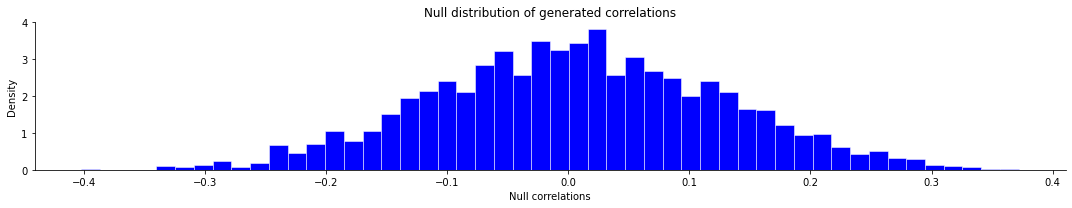

In [83]:
spin_test_neurosynth = SpinPermutationTest_Schaefer400(x = R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, y = neurosynth_fsaverage_wb, correlation_type = 'spearman')
#null_distr_rvals.append(null_distribution_neurosynth)

### Abagen

In [56]:
neuromap.append('abagen')
r_vals.append(stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, abagen_fsaverage_wb, nan_policy='omit')[0])
p_vals.append(stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, abagen_fsaverage_wb, nan_policy='omit')[1])
stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, abagen_fsaverage_wb, nan_policy='omit')

SpearmanrResult(correlation=-0.12662605613581857, pvalue=1.0017781604157069e-66)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Spin permutation test p-value: 0.024


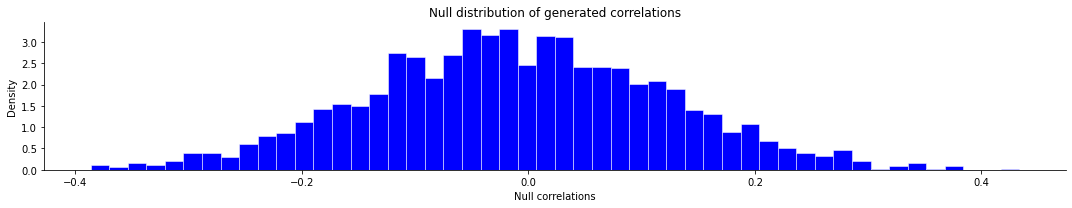

In [57]:
null_distribution_abagen = SpinPermutationTest_Schaefer400(x = R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, y = abagen_fsaverage_wb, correlation_type = 'spearman')
null_distr_rvals.append(null_distribution_abagen)

### CBF

In [58]:
neuromap.append('cbf')
r_vals.append(stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, cbf_fsaverage_wb, nan_policy='omit')[0])
p_vals.append(stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, cbf_fsaverage_wb, nan_policy='omit')[1])
stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, cbf_fsaverage_wb, nan_policy='omit')

SpearmanrResult(correlation=0.35221869679725354, pvalue=0.0)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Spin permutation test p-value: 0.008


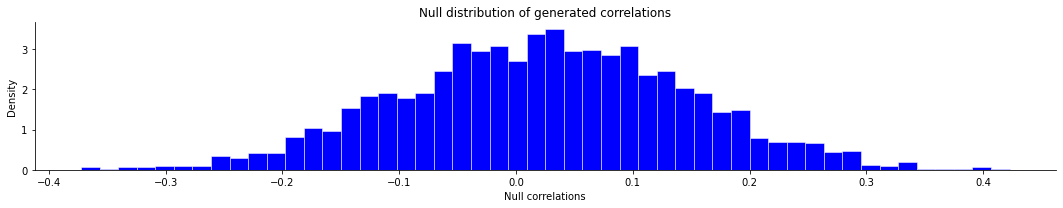

In [59]:
null_distribution_cbf = SpinPermutationTest_Schaefer400(x = R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, y = cbf_fsaverage_wb, correlation_type = 'spearman')
null_distr_rvals.append(null_distribution_cbf)

### Dopamine

In [60]:
neuromap.append('dopamine')
r_vals.append(stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, dopa_fsaverage_wb, nan_policy='omit')[0])
p_vals.append(stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, dopa_fsaverage_wb, nan_policy='omit')[1])
stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, dopa_fsaverage_wb, nan_policy='omit')

SpearmanrResult(correlation=0.1274043840173844, pvalue=7.210485403416565e-75)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Spin permutation test p-value: 0.4625


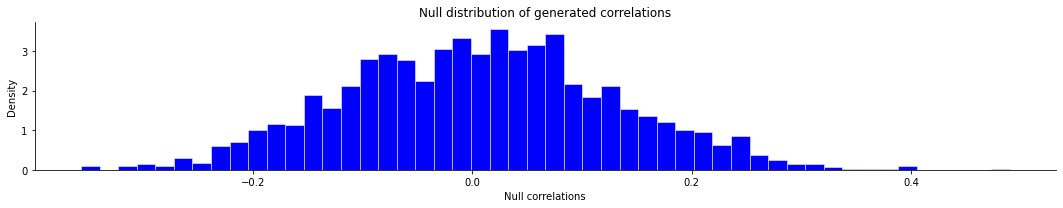

In [61]:
null_distribution_dopamine = SpinPermutationTest_Schaefer400(x = R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, y = dopa_fsaverage_wb, correlation_type = 'spearman')
null_distr_rvals.append(null_distribution_dopamine)

### Acetylcholine

In [62]:
neuromap.append('acetylcholine')
r_vals.append(stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, acetylcholine_fsaverage_wb, nan_policy='omit')[0])
p_vals.append(stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, acetylcholine_fsaverage_wb, nan_policy='omit')[1])
stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, acetylcholine_fsaverage_wb, nan_policy='omit')

SpearmanrResult(correlation=0.12267946284331986, pvalue=1.6328104985290438e-69)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Spin permutation test p-value: 0.1675


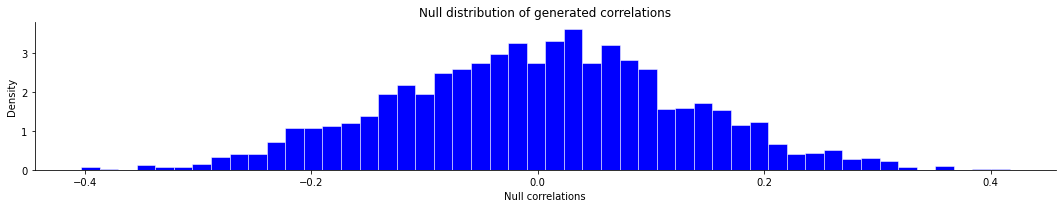

In [63]:
null_distribution_acetylcholine = SpinPermutationTest_Schaefer400(x = R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, y = acetylcholine_fsaverage_wb, correlation_type = 'spearman')
null_distr_rvals.append(null_distribution_acetylcholine)

### Serotonin transporter

In [64]:
neuromap.append('serotonin')
r_vals.append(stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, sert_fsaverage_wb, nan_policy='omit')[0])
p_vals.append(stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, sert_fsaverage_wb, nan_policy='omit')[1])
stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, sert_fsaverage_wb, nan_policy='omit')

SpearmanrResult(correlation=0.03190882240817313, pvalue=4.932516434127591e-06)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Spin permutation test p-value: 0.241


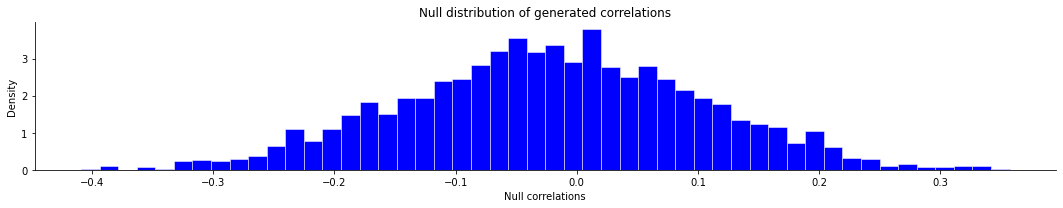

In [65]:
null_distribution_serotonin = SpinPermutationTest_Schaefer400(x = R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, y = sert_fsaverage_wb, correlation_type = 'spearman')
null_distr_rvals.append(null_distribution_serotonin)

### Norepinephrin

In [66]:
neuromap.append('norepinephrin')
r_vals.append(stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, norepinephrin_fsaverage_wb, nan_policy='omit')[0])
p_vals.append(stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, norepinephrin_fsaverage_wb, nan_policy='omit')[1])
stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, norepinephrin_fsaverage_wb, nan_policy='omit')

SpearmanrResult(correlation=0.02629108622579683, pvalue=0.00016777283948677215)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Spin permutation test p-value: 0.187


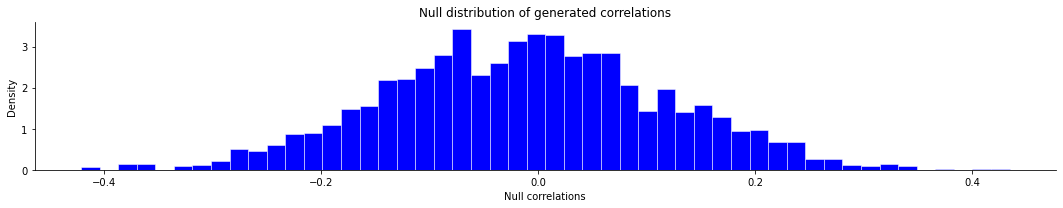

In [67]:
null_distribution_norepinephrin = SpinPermutationTest_Schaefer400(x = R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, y = norepinephrin_fsaverage_wb, correlation_type = 'spearman')
null_distr_rvals.append(null_distribution_norepinephrin)

### Glucose

In [68]:
neuromap.append('glucose')
r_vals.append(stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, glucose_fsaverage_wb, nan_policy='omit')[0])
p_vals.append(stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, glucose_fsaverage_wb, nan_policy='omit')[1])
stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, glucose_fsaverage_wb, nan_policy='omit')

SpearmanrResult(correlation=0.21475381938031016, pvalue=2.650163097978465e-212)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Spin permutation test p-value: 0.0335


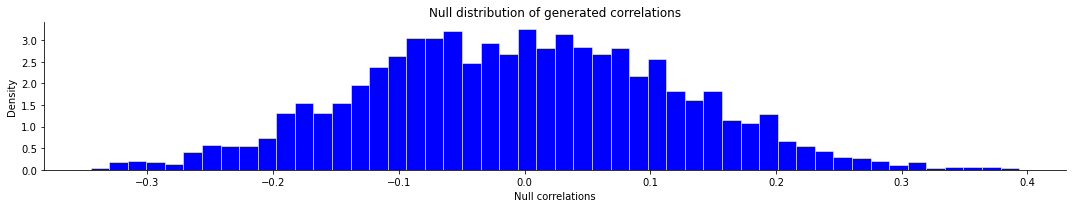

In [69]:
null_distribution_glucose = SpinPermutationTest_Schaefer400(x = R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5, y = glucose_fsaverage_wb, correlation_type = 'spearman')
null_distr_rvals.append(null_distribution_glucose)

### Developmental expansion

In [71]:
neuromap.append('developmental expansion')
r_vals.append(stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5[10242:], devexp_fsaverage_rh, nan_policy='omit')[0])
p_vals.append(stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5[10242:], devexp_fsaverage_rh, nan_policy='omit')[1])
stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5[10242:], devexp_fsaverage_rh, nan_policy='omit')

SpearmanrResult(correlation=0.01885571407159875, pvalue=0.056656748290939536)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Spin permutation test p-value: 0.4445


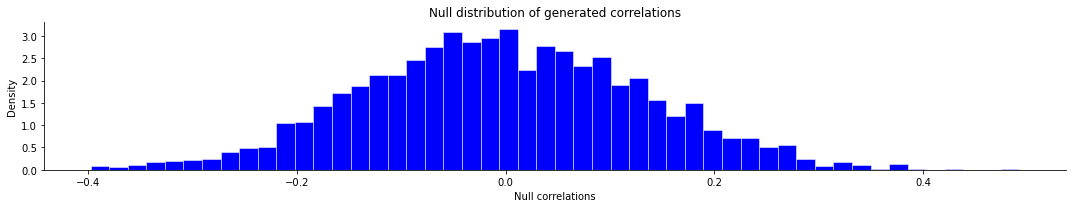

In [70]:
null_distribution_devexp = SpinPermutationTest_Schaefer400(x = R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5[10242:], y = devexp_fsaverage_rh, correlation_type = 'spearman')
null_distr_rvals.append(null_distribution_devexp)

### Evolutionary expansion

In [72]:
neuromap.append('evolutionary expansion')
r_vals.append(stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5[10242:], evoexp_fsaverage_rh, nan_policy='omit')[0])
p_vals.append(stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5[10242:], evoexp_fsaverage_rh, nan_policy='omit')[1])
stats.spearmanr(R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5[10242:], evoexp_fsaverage_rh, nan_policy='omit')

SpearmanrResult(correlation=0.25118741189319693, pvalue=8.265921926502586e-147)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Spin permutation test p-value: 0.012


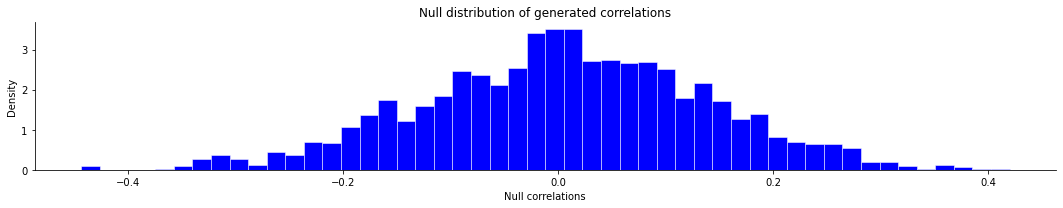

In [73]:
null_distribution_evoexp = SpinPermutationTest_Schaefer400(x = R_lmer_hemi_fc_G1_sex_contrast_res_tval_fs5[10242:], y = evoexp_fsaverage_rh, correlation_type = 'spearman')
null_distr_rvals.append(null_distribution_evoexp)

### Results summary with FDR correction

In [284]:
neuromaps_res = {'neuromaps': neuromap, 
                 'spearman (r)': r_vals,
                 'uncorrected p': p_vals,
                 'spin p': [0.046,0.0125,0.0135,0.4615,0.1645,0.2425,0.1815,0.04,0.449,0.0115],
                 'spin q': fdrcorrection(pvals = spin_p_vals, alpha=0.05)[1],
                 'significance (FDR-corrected)': fdrcorrection(pvals = spin_p_vals, alpha=0.05)[0]}

neuromaps_res = pd.DataFrame(neuromaps_res)
neuromaps_res

,neuromaps,spearman (r),uncorrected p,spin p,spin q,significance (FDR-corrected)
0,neurosynth,0.023635,7.172609e-04,0.0460,0.106000,False
1,abagen,-0.126626,1.001778e-66,0.0125,0.045000,True
2,cbf,0.352219,0.000000e+00,0.0135,0.045000,True
3,dopamine,0.127404,7.210485e-75,0.4615,0.461500,False
4,acetylcholine,0.122679,1.632810e-69,0.1645,0.259286,False
5,serotonin,0.031909,4.932516e-06,0.2425,0.303125,False
6,norepinephrin,0.026291,1.677728e-04,0.1815,0.259286,False
7,glucose,0.214754,2.650163e-212,0.0400,0.100000,False
8,developmental expansion,0.018856,5.665675e-02,0.4490,0.461500,False
9,evolutionary expansion,0.251187,8.265922e-147,0.0115,0.045000,True


#### Export results dataframe to csv

In [285]:
neuromaps_res.to_csv(resdir_hcp+'neuromaps_res.csv', header = True, index = True)

In [ ]:
### Violin plot of t-values (null distributions) by Yeo network - in order to show where the empirical t-value is located

WN_dispersion_perm_tval_sex_contrast_null_distr_long = pd.melt(WN_dispersion_perm_tval_sex_contrast_null_distr, 
                                                               value_vars = WN_dispersion_perm_tval_sex_contrast_null_distr.columns.tolist(), 
                                                               var_name = 'yeo_network', value_name='t_vals', ignore_index=False)

fig, ax = plt.subplots(figsize=(15, 5))


sns.violinplot(data = WN_dispersion_perm_tval_sex_contrast_null_distr_long,
                    x="yeo_network",
                    y="t_vals",
                    #hue="",
                    palette = palette_labeled_networks,
                    split = False)

ax.axes.set_title("Within network dispersion null distributions of t-values (for sex contrast)", y=1.05, fontsize=20)
ax.set_xlabel("Yeo network",fontsize=20)
ax.set_ylabel("t-value",fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xticklabels('', rotation=40, ha="right") 
#ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")  # to show tick labels

#plt.show()

# save figure in directory 
plt.savefig(resdir_fig+'HCP_violin_WN_dispersion_null_distr_tvals.png', dpi=300, bbox_inches="tight")  # bbox_inches is so that the figure doesn't get cut off when saving